In [1]:
from pyopenms import *
import os
import pandas as pd
import numpy as np
import re
from matplotlib_venn import venn3
from matplotlib_venn import venn2
import matplotlib.pyplot as plt


In [2]:
def sage_vs_oms(sage, oms):
    if pd.isna(sage) or pd.isna(oms):
        return False
    
    modifications = {'(Oxidation)' : "[+15.9949]",
                     '(Carbamidomethyl)' : '[+57.0215]'
                    }
    sage2 = sage.replace("[+0]-", "")
    oms2 = oms
    for mod, mass in modifications.items() :
        oms2 = oms2.replace(mod, mass)
        
    return oms2 == sage2


    

In [3]:
def process_files_in_folder(folder_path):
    # Get a list of all files in the specified folder
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Process each file
    df = pd.DataFrame({"File":[], "SpectrumID":[], "Sequence":[]})
    for file_name in files:
        file_path = os.path.join(folder_path, file_name)
        
        
        if file_name.endswith(".idXML") and "FDR" in file_name:
            df = pd.concat([df,read_idxml_file(file_path, file_name)], ignore_index=True)
        if file_name.endswith(".csv") :
            
            concat_csv = pd.read_csv(file_path)
            concat_csv2 = pd.DataFrame({"File":file_name[-7:-4], "SpectrumID" : concat_csv["SpectrumID"], "Sequence" : concat_csv[" Sequence"]})
            df = pd.concat([df, concat_csv2])
    
    return df

def read_idxml_file(idxml_file_path, file):
    idxml_file = IdXMLFile()

    # Create an MSExperiment object to store the data
    experiment = []
    protein_ids= []
    
    # Read the idXML file
    idxml_file.load(idxml_file_path,protein_ids, experiment)
    
    ids = []
    sequences = []

    # Access the data in the experiment object
    for spectrum in experiment:
        
        
        for peptide_hit in spectrum.getHits():
            ids.append(spectrum.getMetaValue("spectrum_reference"))
            
            sequences.append(peptide_hit.getSequence().toString())
            
            
    
    return pd.DataFrame({"File": file[-9:-6], "SpectrumID": ids, "Sequence" : sequences})
    





In [4]:
df_sage_complete = pd.read_csv("temp_data/results.sage.tsv", sep = '\t')
df_sage_complete = df_sage_complete[df_sage_complete['matched_peaks'] > 5]

df_sage = pd.DataFrame()
df_sage["File"] = df_sage_complete["filename"].apply(lambda x: x[-8:-5])
df_sage["SpectrumID"] = df_sage_complete["scannr"]
df_sage["Sequence"] = df_sage_complete["peptide"]

df_sage["Sequence"] = df_sage["Sequence"].apply(lambda x: x.replace("[+15.9949]", "(Oxidation)").replace('[+57.0215]', '(Carbamidomethyl)').replace("[+0]-", ""))


In [5]:
df1 = process_files_in_folder("temp_data/SimpleSearch")
df1["Sequence_Simple"] = df1["Sequence"]
df1 = df1.drop("Sequence", axis = 1)
df2 = process_files_in_folder("temp_data/PeptideSearch")
df2["Sequence_Peptide"] = df2["Sequence"]
df2= df2.drop("Sequence", axis = 1)


In [6]:
# Prep Venns
sage_venn = set([row["File"] + row["SpectrumID"] + row["Sequence"] for _, row in df_sage.iterrows()])
sage_s = set([row["File"] + row["SpectrumID"] + row["Sequence_Simple"] for _, row in df1.iterrows()])
sage_p = set([row["File"] + row["SpectrumID"] + row["Sequence_Peptide"] for _, row in df2.iterrows()])

In [52]:
def change_labels(idx, extra_text, venn_diagram, position_shift, colorchange):
    #function to change the labels
    p = venn_diagram.get_label_by_id(idx).get_position()
    t = venn_diagram.get_label_by_id(idx).get_text()
    c = venn_diagram.get_patch_by_id(idx).get_facecolor()
    venn_diagram.get_label_by_id(idx).set_text(extra_text+ t)
    if colorchange:
        venn_diagram.get_label_by_id(idx).set_color(c)
    venn_diagram.get_label_by_id(idx).set_position((p[0]*position_shift, p[1]*position_shift))
    venn_diagram.get_label_by_id(idx).set_size(14)

IndentationError: unexpected indent (1052931453.py, line 10)

(-0.6794727440501158, 0.1233813272453343)


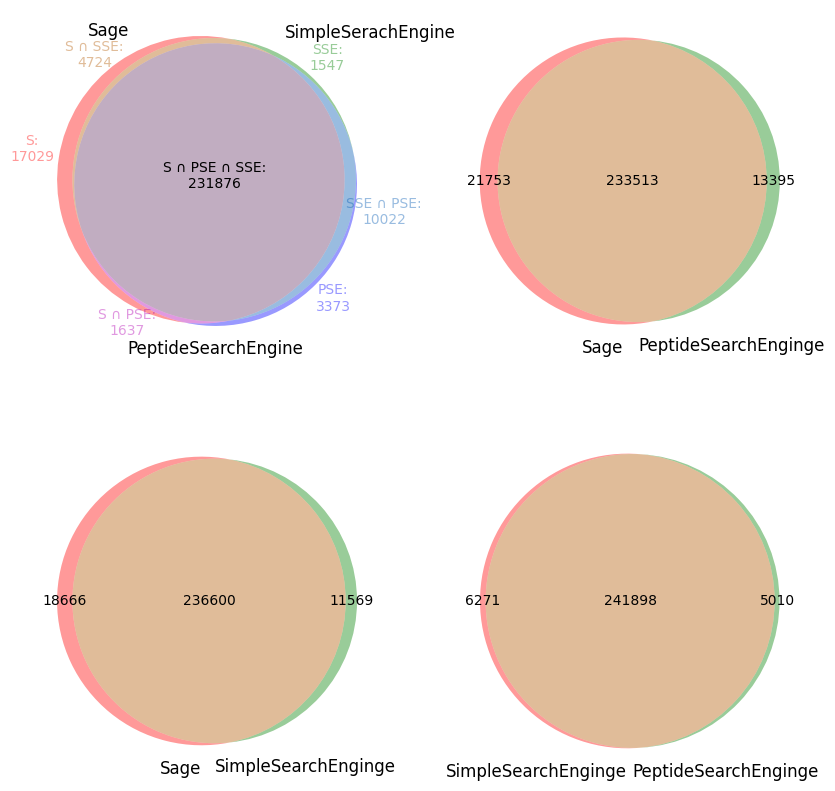

In [51]:
# VENN DIAGRAMS
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
venn_diagram = venn3([sage_venn, sage_s, sage_p],set_labels= ('Sage', 'SimpleSerachEngine', 'PeptideSearchEngine'), ax = axes[0,0])
change_labels('100', "S:\n", venn_diagram,1.4, True)
change_labels('010', "SSE:\n", venn_diagram,1.2, True)
change_labels('001', "PSE:\n", venn_diagram,1.2, True)
change_labels('110', "S \u2229 SSE:\n", venn_diagram,1.3, True)
change_labels('101', "S \u2229 PSE:\n", venn_diagram,1.2, True)
change_labels('011', "SSE \u2229 PSE:\n", venn_diagram,1.4, True)
change_labels('111', "S \u2229 PSE \u2229 SSE:\n", venn_diagram,1.3, False)

print(venn_diagram.get_label_by_id('100').get_position())

vd2 = venn2([sage_venn, sage_s], set_labels=("Sage", "SimpleSearchEnginge"), ax = axes[1,0])
vd3 = venn2([sage_venn, sage_p], set_labels=("Sage", "PeptideSearchEnginge"), ax = axes[0,1])
vd4 = venn2([sage_s, sage_p], set_labels=("SimpleSearchEnginge", "PeptideSearchEnginge"), ax = axes[1,1])
plt.savefig("FIID_overlaps.png",  bbox_inches = 'tight', dpi = 500)

# next we look into the open search


In [6]:
merged = pd.merge(df1, df2, on = ["File", "SpectrumID"], how = "outer")
merged = merged.merge(df_sage, on = ["File", "SpectrumID"], how = "outer")
merged



,File,SpectrumID,Sequence_Simple,Sequence_Peptide,Sequence
0,1-A,controllerType=0 controllerNumber=1 scan=1230,ISENGQR,ISENGQR,[+0]-ISENGQR
1,1-A,controllerType=0 controllerNumber=1 scan=1257,KDELER,KDELER,[+0]-KDELER
2,1-A,controllerType=0 controllerNumber=1 scan=1456,EEETVAK,NaN,NaN
3,1-A,controllerType=0 controllerNumber=1 scan=1547,HGYIR,HGYIR,[+0]-HGYIR
4,1-A,controllerType=0 controllerNumber=1 scan=1662,HGYIR,HGYIR,[+0]-HGYIR
...,...,...,...,...,...
301749,3_B,controllerType=0 controllerNumber=1 scan=48772,NaN,NaN,[+0]-M[+15.9949]IPGAKPLQVGDVVSTTAVIESVVNQPTGK
301750,4_B,controllerType=0 controllerNumber=1 scan=51877,NaN,NaN,[+0]-LGKPLDVVIPIGVLIK
301751,3_C,controllerType=0 controllerNumber=1 scan=51165,NaN,NaN,[+0]-LGKPLDVVIPIGVLIK
301752,4-A,controllerType=0 controllerNumber=1 scan=34294,NaN,NaN,[+0]-DNLTLWTSDISESGQEDQQQQQQQQQQQQQQQQQAPAEQTQ...


In [7]:
def equ(a, b):
    return (a == b) and not pd.isna(a) and not pd.isna(b)


def compute_overlap(df, col_a, col_b, compare_fct):
    def not_equ(a,b):
        if pd.isna(a) != pd.isna(b):
            return True
        if pd.isna(a) and pd.isna(b):
            return False
        return not compare_fct(a, b)
        
        
    inner = sum(df.apply(lambda x : (compare_fct(x[col_a], x[col_b])), axis = 1))
    outer = sum(df.apply(lambda x:  (not_equ(x[col_a], x[col_b])), axis = 1))
    
    return inner / (outer + inner)

In [8]:
compute_overlap(merged, "Sequence", "Sequence_Simple", sage_vs_oms)  # sage MUST ALWAYS BE FIRST

0.8115358507140861

In [9]:
compute_overlap(merged, "Sequence", "Sequence_Peptide", sage_vs_oms)  # sage MUST ALWAYS BE FIRST

0.8012980197559404

In [10]:
compute_overlap(merged, "Sequence_Simple", "Sequence_Peptide", equ )

0.957473420888055

**The final output only has a 200348 overlap between the Peptide_Search and sage What would happen if we compare the candidates   and not the final output: **

In [11]:
fi_candidates = process_files_in_folder("temp_data/FragmentIndex_out")
fi_candidates["Sequence"] = fi_candidates["Sequence"].apply(lambda x: x.strip())

In [12]:
df_sage_unmod_sequ = df_sage
df_sage_unmod_sequ["Sequence"] = df_sage_unmod_sequ["Sequence"].apply(lambda x: re.sub('[^A-Za-z]+', '', x))

In [13]:
def coverage_with_candidates(df_candidates, df_compare):
    merged_candidates = pd.merge(df_candidates, df_compare, on = ["File", "SpectrumID", "Sequence"])
    non_ided = merged_candidates.merge(df_compare, on = ["File", "SpectrumID"], how = "outer").shape[0] - merged_candidates.shape[0]
    return (df_compare.shape[0] - non_ided) / df_compare.shape[0]

In [14]:
coverage_with_candidates(fi_candidates, df_sage_unmod_sequ)

0.9483351816469142

In [24]:
df1 = process_files_in_folder("temp_data/SimpleSearch")
df1["Sequence"] = df1["Sequence"].apply(lambda x: x.replace("(Oxidation)","").replace("(Carbamidomethyl)", ""))
                    
df2 = process_files_in_folder("temp_data/PeptideSearch")
df2["Sequence"] = df2["Sequence"].apply(lambda x: x.replace("(Oxidation)", "").replace("(Carbamidomethyl)",""))

In [25]:
coverage_with_candidates(fi_candidates, df1)

0.9769511905193639

In [26]:
coverage_with_candidates(fi_candidates, df2)

0.9999918998169358